In [1]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

import fiftyone as fo

from tator_tools.download_media import MediaDownloader
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer
from tator_tools.download_datasets import DatasetDownloader
from tator_tools.yolo_dataset import YOLODataset

# Download Media (frames) from Tator

In [ ]:
# Initialize the downloader with the required parameters
downloader = MediaDownloader(
    api_token=os.getenv("TATOR_TOKEN"),
    project_id=155,
    output_dir="../Data"
)

# Download the media
media_ids = ["14759824"]

In [ ]:
downloader.download_data(media_ids, 
                         convert=False, 
                         extract=True, 
                         every_n_seconds=3)

In [ ]:
downloader.data

# View Clustered Frames from Tator using Fiftyone

In [ ]:
# Initialize the viewer with the path to the directory containing images
viewer = FiftyOneDatasetViewer(image_dir=downloader.media_path_map['14759824']['frames'])

# Process the dataset to create the FiftyOne dataset and generate the UMAP visualization
viewer.process_dataset()

In [ ]:
# Launch the FiftyOne app
try:
    session = fo.launch_app(viewer.dataset)
except:
    session = fo.launch_app(viewer.dataset)

# Download Datasets from Tator

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 155  # 70

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiIkY3JlYXRlZF9ieSIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjo1MDZ9LHsibWV0aG9kIjoiT1IiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiIkdHlwZSIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjo0NjB9LHsiYXR0cmlidXRlIjoiJHR5cGUiLCJvcGVyYXRpb24iOiJlcSIsImludmVyc2UiOmZhbHNlLCJ2YWx1ZSI6NTUzfV19XX0="

# Demo for downloading labeled data
frac = 1.0

dataset_name = "AUV_Polygons"
output_dir = "../Data/Labeled_Data"

label_field = "Label"

In [3]:
# Create a downloader for the labeled data
downloader = DatasetDownloader(api_token,
                               project_id=project_id,
                               search_string=search_string,
                               frac=frac,
                               output_dir=output_dir,
                               dataset_name=dataset_name,
                               label_field=label_field)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\search_string.txt


In [4]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 8645 localizations


Processing query: 100%|██████████| 8645/8645 [00:00<00:00, 9365.45it/s]


NOTE: Found 8645 localizations after sampling
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\data.csv
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\data.json
NOTE: Downloading images to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\images


NOTE: Images downloaded to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\images


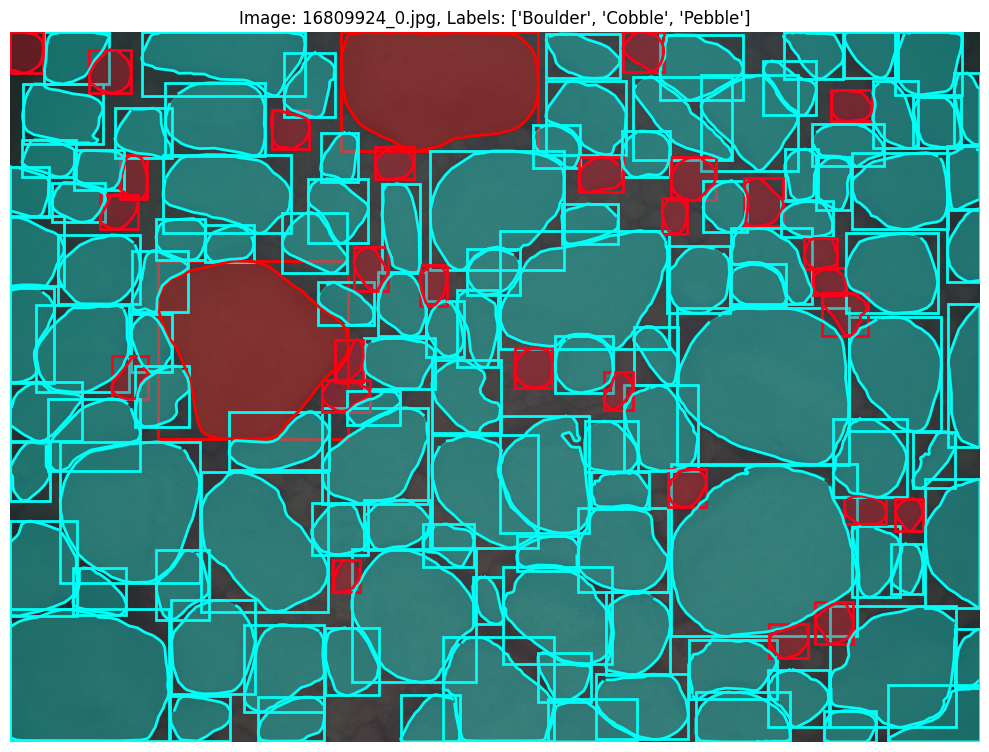

In [5]:
downloader.display_sample()

In [6]:
df = downloader.as_dataframe()  # .as_dict()
df.head(3)

# Do some data exploration, filtering as needed

,media,frame,image_name,image_path,x,y,width,height,polygon,label
0,16814883,0,16814883_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.512695,0.218,0.006592,0.011000,"[[0.51416015625, 0.21833333333333332], [0.5129...",Pebble
1,16814812,0,16814812_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.761475,0.911,0.008545,0.013000,"[[0.767578125, 0.911], [0.763916015625, 0.9113...",Pebble
2,16814894,0,16814894_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.757812,0.613,0.006592,0.010667,"[[0.762939453125, 0.6133333333333333], [0.7602...",Pebble


# Convert Data into YOLO-formatted Dataset

In [7]:
# Set parameters
output_dir = "../Data/Labeled_Data/AUV_Polygons"
dataset_name = "YOLODataset_Segmentation"

train_ratio = 0.8
test_ratio = 0.1

task = 'segment' # 'detect' or 'segment'

In [8]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task
)

In [9]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

Processing YOLO dataset with 8645 annotations...
Dataset split: 160 train, 20 valid, 20 test images


Writing segmentation labels:   0%|          | 0/200 [00:00<?, ?it/s]

Copying images:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset created at e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Segmentation
Classes: ['Pebble', 'Fallen Wood', 'Woody Debris', 'Unknown', '', 'Cobble', 'Boulder', 'Pebbles', 'Pebble Bed', 'Pebble bed', 'Fine Sediment']


Rendering Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Rendered 10 examples to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Segmentation\examples
